# LSTM-based Variational Autoencoder for Clinical Notes Encoding
The LSTM-based variational autoencoder (https://arxiv.org/pdf/1312.6114.pdf) for encoding clinical note to a latent vector representation. This representation can be used for computing similarity metrics between documents (sentences, in this case) or as a feature vector for other learning tasks.

The VAE is a generative model that maximizes the marginal probability of the input by conditioning it on a latent variable whose distribution is learned by a parameterized function estimator, such as a neural network. The neural network samples z from a normal distribution and transforms it to a distribution Q(z|X) to give us a distribution of z values given X which are likely to produce X. This is where the "Variational" part of VAE's comes in: we use KL-divergence in our loss function to drive Q(z|X) as close as we can to P(z), the prior distribution of z. The loss function also includes a reconstruction error term. In summary, the VAE learns an encoding distribution Q which produces latent representations z which are likely to produce the input data X, and a decoding function f(z) which is optimized to output data as close to X as it can from the latent representation.


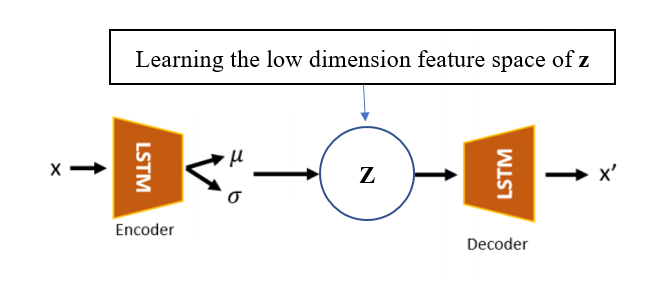

We can also improve the model with bidirectional-LSTM-based

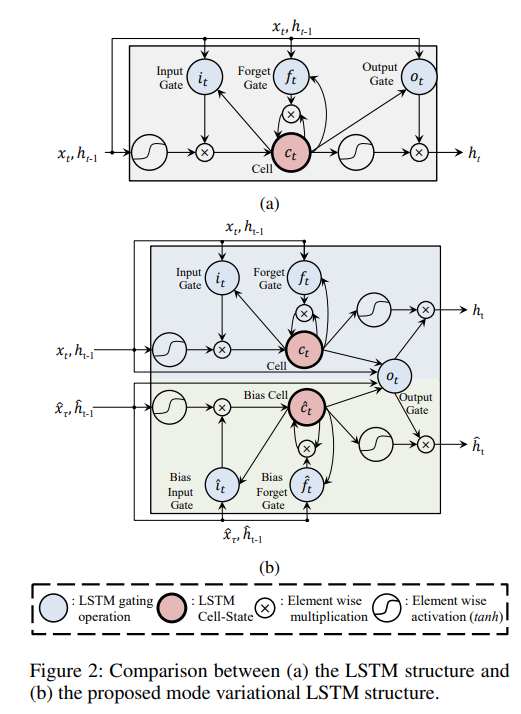

In [1]:
from utils import *
from vae_lstm import *
import numpy as np

C:\Users\adamm\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\adamm\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Get Data
We will be building our dataset by converting sentences from various NLTK corpora (Brown, Reuters, Gutenberg) into a word embedding representation which will yield a 3D tensor of shape (N, S, E), where N is the number of sentences, S is the length of the sentence (zero padded at the beginning), and E is the length of the word embedding. Here we're using S=20 and E=300. We're using the wiki-news-300d-1M.vec from https://fasttext.cc/docs/en/english-vectors.html for our word embeddings.

In [ ]:
data, all_text = get_data()

len_train = 50000
len_test = 10000
train = data[:len_train]
train_text = all_text[:len_train]
test = data[len_train:len_train + len_test]

batch_size = 50
epochs = 30
input_dim = train.shape[-1]
timesteps = train.shape[1]

## Train the Model
We will train the model for 30 epochs with a batch size of 50. Our displayed loss is mean squared error between the generated word vectors in the output sequence and the word vectors in the input sequence. 

In [2]:
model = VAE_LSTM(input_dim=input_dim, latent_dim=100, hidden_dims=[32], timesteps=timesteps, batch_size=batch_size)
vae, encoder, generator = model.autoencoder, model.encoder, model.generator

vae.fit(train, train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(test, test))

Train on 37751 samples, validate on 0 samples
Epoch 1/30
37751/37751 [==============================] - 64s 2ms/step - loss: 0.0071
Epoch 2/30
37751/37751 [==============================] - 59s 2ms/step - loss: 0.0069
Epoch 3/30
37751/37751 [==============================] - 59s 2ms/step - loss: 0.0068
Epoch 4/30
37751/37751 [==============================] - 58s 2ms/step - loss: 0.0067
Epoch 5/30
37751/37751 [==============================] - 59s 2ms/step - loss: 0.0066
Epoch 6/30
37751/37751 [==============================] - 59s 2ms/step - loss: 0.0066
Epoch 7/30
37751/37751 [==============================] - 59s 2ms/step - loss: 0.0065
Epoch 8/30
37751/37751 [==============================] - 59s 2ms/step - loss: 0.0065
Epoch 9/30
37751/37751 [==============================] - 59s 2ms/step - loss: 0.0064
Epoch 10/30
37751/37751 [==============================] - 59s 2ms/step - loss: 0.0064
Epoch 11/30
37751/37751 [==============================] - 58s 2ms/step - loss: 0.0063
Epoch 

## Check Similar Sentences
We'll do a spot check on our model by printing the text of the most similar sentences in the encoding space for a few training examples.

In [5]:
encoded_sentences = encoder.predict(np.array(train), batch_size = batch_size)

In [54]:
def print_nearest_sentences(sent_idx, sentence_embeddings):
    print("[First sentence is target sentence, following are closest neighbors]")
    for s in get_nearest_sentences(sent_idx, sentence_embeddings, train):
        print(s)
    print()
        
print_nearest_sentences(12352, encoded_sentences)
print_nearest_sentences(5226, encoded_sentences)
print_nearest_sentences(35233, encoded_sentences)

[First sentence is target sentence, following are closest neighbors]
it said after nine months following closing may require royal to register the 200 000 shares for sale . 
under terms of the letter of intent would contribute substantially to a three year exploration budget of 4 . 
to fully compensate for devaluation the quota would have to be around 28 dlrs per bag against 7 . 
economists polled by reuters said that m 1 should be anywhere from down four billion dlrs to up 2 . 
like its cousin the refrigerator a conditioner can be expected to last 20 to 25 years or more . 
economists polled by reuters said that m 1 would be anywhere from down two billion dlrs to up 1 . 

[First sentence is target sentence, following are closest neighbors]
1 mln dlr defense logistics agency contract for jet fuel the defense department said . 
12 mln tonnes in 1985 the commodity board for margarine fats and oils said . 
7 mln dlrs manufactures a line of computer output to microfilm hardware and . 
13 ml

It looks like our model is learning some notion of sentence structure. The first example has sentences which all discuss a subject with some relationship to a number at the end of the sentence. Similarly, the second example has sentences which all begin with some number of some unit and end with a '[subject] said'. The final example has sentences which all begin with a simple '[pronoun] [verb]' structure. While sentence structure is important, the final example shows that the model may not be representing topics very well in addition to structure. Perhaps using a model like the Dirichlet Variational Autoencoder (https://arxiv.org/pdf/1811.00135.pdf), which explicitly models topics in its latent representation using a dirichlet distribution, would improve the representations in that regard.

### Compare with Average Word Embedding Representation
We can use a much simpler method for representing sentences as a vector that captures content and structure: use a weighted average of the word2vec word embeddings in the sentence matrix, since each word in a word2vec word embedding captures its contextual relationship to other words. We will simply take an unweighted average in this example, but we can imagine lemmatizing the words, weighting words in the sentence based on parts of speech and tf-idf scores, removal of stop words, and so forth to yield more meaningful sentence representations. Let's use the same examples above and see what our average sentence vectors give for the most similar sentences:

In [55]:
def get_avg_sentence_embeddings(sentence_vecs):
    return np.average(sentence_vecs, axis=1)

sentence_embeddings = get_avg_sentence_embeddings(train)
sentence_embeddings.shape
print_nearest_sentences(12352, sentence_embeddings)
print_nearest_sentences(5226, sentence_embeddings)
print_nearest_sentences(35233, sentence_embeddings)

[First sentence is target sentence, following are closest neighbors]
it said after nine months following closing may require royal to register the 200 000 shares for sale . 
it said had a 30 day call option nine months from closing to buy from h . 
in addition the company said it authorized another 800 000 shares but would not issue them at this time . 
the company said it will lease the ships for three years and hold two additional three year options . 
said receipt of 2 500 000 shares would raise its interest in to about 59 . 
the company said it is evaluating two separate proposals and will complete the sale within 10 days . 

[First sentence is target sentence, following are closest neighbors]
1 mln dlr defense logistics agency contract for jet fuel the defense department said . 
1 mln dlr provision for future losses from several major projects in defense contractor subsidiary . 
1 mln dlr defense contract refining and marketing inc is being awarded a 84 . 
9 mln dlr in credits fro

### Doc2Vec
Rather than doing a weighted average of individual word embeddings, which loses the ordering of the sentences, we could directly learn an entire sentence embedding.

Doc2vec (or Paragraph Vectors: https://arxiv.org/pdf/1405.4053v2.pdf) learns a dense vector representation of a variable length sequence of words by learning to predict the next word in a sequence given the current paragraph vector concatenated with subsequent word vectors in the sequence. Just as the LSTM-based VAE, doc2vec encodes word ordering into its representation, and doc2vec has the advantage of allowing variable sized input, where with the VAE we need a fixed size input (which we handled by zero-padding sequences to be the right size).

Let's train a doc2vec model using the Python NLP package, Gensim (https://radimrehurek.com/gensim/models/doc2vec.html) and view some similarity examples from the trained model.

In [61]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import reuters, gutenberg, brown, treebank
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = all_text
tagged_documents = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(documents)]

vector_size = 20
alpha = 0.025

d2v = Doc2Vec(vector_size=vector_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1)
  
d2v.build_vocab(tagged_documents)

epochs = 100

for epoch in range(epochs):
    print('epoch {0}'.format(epoch), end='...')
    d2v.train(tagged_documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)
    d2v.alpha -= 0.0002
    d2v.min_alpha = d2v.alpha

epoch 0...epoch 1...epoch 2...epoch 3...epoch 4...epoch 5...epoch 6...epoch 7...epoch 8...epoch 9...epoch 10...epoch 11...epoch 12...epoch 13...epoch 14...epoch 15...epoch 16...epoch 17...epoch 18...epoch 19...epoch 20...epoch 21...epoch 22...epoch 23...epoch 24...epoch 25...epoch 26...epoch 27...epoch 28...epoch 29...epoch 30...epoch 31...epoch 32...epoch 33...epoch 34...epoch 35...epoch 36...epoch 37...epoch 38...epoch 39...epoch 40...epoch 41...epoch 42...epoch 43...epoch 44...epoch 45...epoch 46...epoch 47...epoch 48...epoch 49...epoch 50...epoch 51...epoch 52...epoch 53...epoch 54...epoch 55...epoch 56...epoch 57...epoch 58...epoch 59...epoch 60...epoch 61...epoch 62...epoch 63...epoch 64...epoch 65...epoch 66...epoch 67...epoch 68...epoch 69...epoch 70...epoch 71...epoch 72...epoch 73...epoch 74...epoch 75...epoch 76...epoch 77...epoch 78...epoch 79...epoch 80...epoch 81...epoch 82...epoch 83...epoch 84...epoch 85...epoch 86...epoch 87...epoch 88...epoch 89...epoch 90...epoch 91.

In [71]:
def find_sentence(sentences, by_words):
    filtered = []
    i = 0
    for s in sentences:
        is_found = True
        for w in by_words:
            if w.lower() not in s.lower():
                is_found = False
        if is_found:
            filtered.append((s, i))
        i += 1
    return filtered

# Get corresponding sentence indexes
print(find_sentence(train_text, ['nine', 'months', 'following']))
print(find_sentence(train_text, ['defense', 'logistics', 'agency', 'contract']))
print(find_sentence(train_text, ['settled', 'accounts', 'sundry', 'business']))

[('it said after nine months following closing  montagu may require royal to register the 200  000 shares for sale .', 20408)]
[('1 mln dlr defense logistics agency contract for jet fuel  the defense department said .', 34050)]
[('he had settled accounts with him for his late agency  and had talked about sundry matters of business .', 28577)]


In [72]:
def print_most_similar(idx, topn=5):
    print(documents[idx])
    for s in d2v.docvecs.most_similar(str(idx), topn=topn):
        print(documents[int(s[0])])
    print()
        
print_most_similar(20408)
print_most_similar(34050)
print_most_similar(28577)

it said after nine months following closing  montagu may require royal to register the 200  000 shares for sale .
5 mln note  company recently spun off from carter hawley hale stores inc  lt  chh .
21 dlr an hour pay raise over the life of the new contract and improved benefits .
31 billion avg shrs 191  100  000 vs 191  500  000 note  earnings include a loss of 3 .
21  dlr  an  hour pay raise over the life of the new contract and improved benefits .
rober kill has withdrawn their proposal to acquire the company ' s stock for 23 .

1 mln dlr defense logistics agency contract for jet fuel  the defense department said .
flag vessels to import 1  500 tonnes of tallow in bulk  an agent for the country said .
agency to review johnson  johnson  lt  jnj  sweetner johnson and johnson said the u .
agriculture department is proposing tighter federal standards setting allowable limits on insect infestations in grain shipments .
parent bank tax payment rose to 244 mln marks last year from 233 mln 